In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sys
sys.path.append('../code')
import dataframe_utilities as util

In [4]:
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials
from functools import partial

# Get Data

In [5]:
df = pd.read_csv('../data/df_w_features.csv', low_memory=False)
df.shape

(24009, 734)

In [6]:
X = df.drop(columns=['home_team_win', 'game_id'])
y = df.home_team_win

In [7]:
X_train = X[:-300]
y_train = y[:-300]
X_valid = X[-300:]
y_valid = y[-300:]

In [9]:
cats = [x for x in X.columns if X[x].dtype=='object']
encoder = ce.CatBoostEncoder(cols=cats, random_state=13)
# encoder = ce.TargetEncoder(cols=cats)
X_train = encoder.fit_transform(X_train, y_train)
X_valid = encoder.transform(X_valid)
cats

['home_team_abbr', 'away_team_abbr', 'home_pitcher', 'away_pitcher']

# Quick Look

In [10]:
xgb_params = {'colsample_bytree': 0.1,
 'learning_rate': 0.01,
 'max_depth': 17,
 'min_child_weight': 16.0,
 'reg_alpha': 103.2815,
 'subsample': 0.55}

In [11]:
gbm = xgb.XGBClassifier(**xgb_params, num_boost_round=100)
model = gbm.fit(X_train, y_train,verbose=False)
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, xgb_test_preds), roc_auc_score(y_valid, xgb_test_preds)

(0.6433333333333333, 0.6346153846153846)

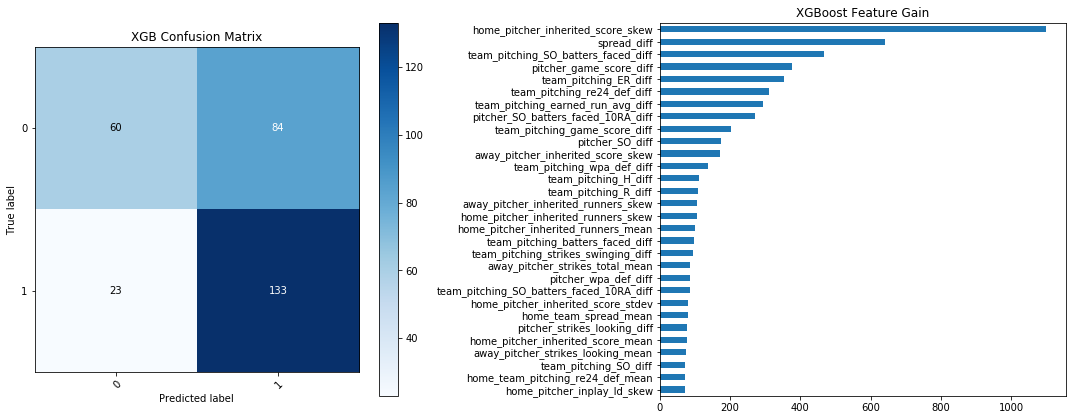

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
x[-30:].plot(kind='barh',ax=ax[1], title="XGBoost Feature Gain")

util.plot_confusion_matrix(y_valid, xgb_test_preds, [0,1], 
                           ax=ax[0], title = "XGB Confusion Matrix")

fig.tight_layout()

# Hyperopt

In [13]:
def xgb_objective(params, data):
    X,y = data
    params['max_depth']=int(params['max_depth'])
    
    np.random.seed(13)
    xgb_class = xgb.XGBClassifier(**params, num_boost_round=100, random_state=13)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    scores = cross_val_score(xgb_class, X, y, cv=kfold, n_jobs=-1, scoring='roc_auc')
    return {'loss': -np.mean(scores), 'status':'ok'}
    
def get_xgbparams(X,y):
    # find hyperparaams
    space = {
        'max_depth':  hp.quniform('max_depth', 10, 30, 1),
        'min_child_weight': hp.quniform('min_child_weight', 2, 20, 1),
        'subsample': hp.quniform('subsample', 0.05, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.05, 1, 0.05),
        'reg_alpha': hp.qloguniform('reg_alpha', -4, 5, 1e-5),
        'learning_rate': hp.qloguniform('learning_rate', -4, -0.5, 1e-2),
    }
    trials = Trials()
    fmin_objective = partial(xgb_objective, data=(X,y))
    
    params = fmin(fmin_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials)
    return params

In [14]:
xgb_params = get_xgbparams(X_train,y_train)
xgb_params['max_depth']=int(xgb_params['max_depth'])
xgb_params

100%|██████████| 50/50 [2:27:47<00:00, 203.19s/it, best loss: -0.6219836928212646]  


{'colsample_bytree': 0.30000000000000004,
 'learning_rate': 0.06,
 'max_depth': 21,
 'min_child_weight': 3.0,
 'reg_alpha': 61.351200000000006,
 'subsample': 1.0}

# Model

In [15]:
# gbm = xgb.XGBClassifier(num_boost_round=100, random_state=13)
gbm = xgb.XGBClassifier(**xgb_params, num_boost_round=100, random_state=13)
model = gbm.fit(X_train, y_train,verbose=False)
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, xgb_test_preds), roc_auc_score(y_valid, xgb_test_preds)

(0.6566666666666666, 0.6517094017094017)

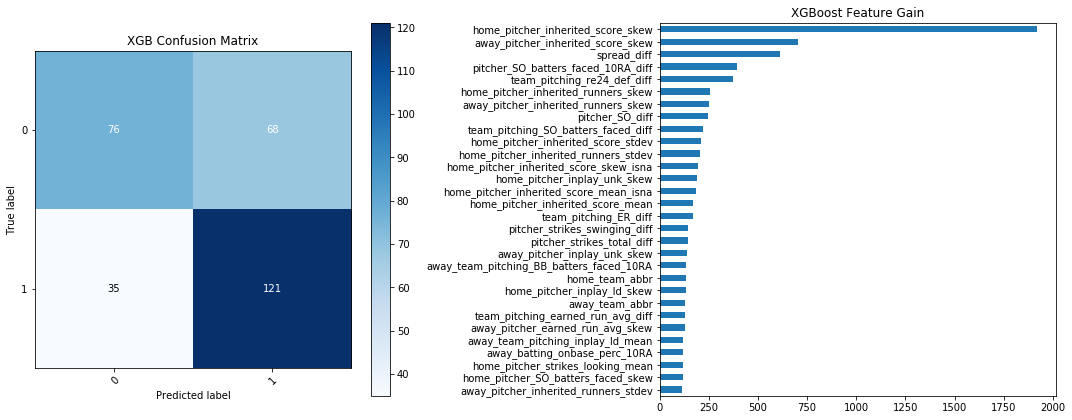

In [16]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
x[-30:].plot(kind='barh',ax=ax[1], title="XGBoost Feature Gain")

util.plot_confusion_matrix(y_valid, xgb_test_preds, [0,1], 
                           ax=ax[0], title = "XGB Confusion Matrix")

fig.tight_layout()